In [3]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


Trial 10 Complete [00h 09m 44s]
val_accuracy: 0.37142857909202576

Best val_accuracy So Far: 0.6857143044471741
Total elapsed time: 01h 07m 42s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8228 - loss: 0.6023 - val_accuracy: 0.6571 - val_loss: 1.1588
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8394 - loss: 0.5718 - val_accuracy: 0.6000 - val_loss: 1.2135
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8421 - loss: 0.4664 - val_accuracy: 0.6857 - val_loss: 1.1313
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9335 - loss: 0.2551 - val_accuracy: 0.7429 - val_loss: 1.0084
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9204 - loss: 0.2911 - val_accuracy: 0.6857 - val_loss: 1.2052
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9436 - loss: 0.2417 - val_accuracy: 0.7143 - val_loss: 1.2714
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9240 - loss: 0.2063 - val_accuracy: 0.7714 - val_loss: 0.9832
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9543 - loss: 0.1697 - val_accuracy: 0.7714 - val_loss: 1.1292
Epo

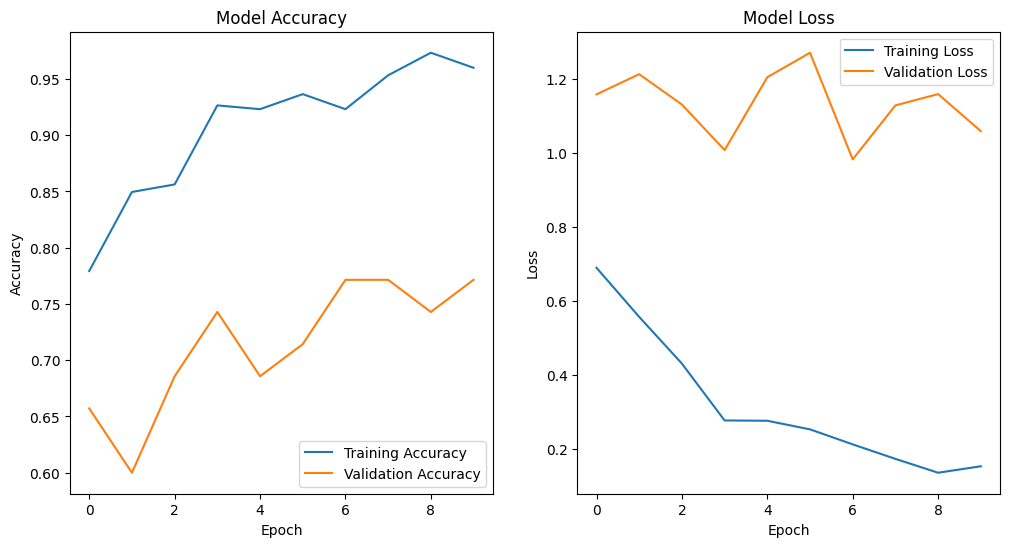

In [ ]:
### i did the heat and trial in multiple cells but here for ease of running the final model, I have created single block
import os
import numpy as np
from datetime import datetime
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch, HyperParameters
from google.colab import drive

### drive mountingg
drive.mount('/content/drive')

### drive path
base_dir = '/content/drive/My Drive/final_project'

###image load
def load_images_based_on_date(directory, split_date):
    X_train, y_train = [], []
    X_val, y_val = [], []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            for image_filename in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_filename)
                image_date = datetime.strptime(image_filename.split('_')[0], '%Y%m%d')
                img = load_img(image_path, target_size=(150, 150))  ##resiz
                img_array = img_to_array(img)
                img_array /= 255.0  #### normalization
                if image_date < datetime(2024, 10, 11):
                    X_train.append(img_array)
                    y_train.append(folder_name)
                else:
                    X_val.append(img_array)
                    y_val.append(folder_name)
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

X_train, y_train, X_val, y_val = load_images_based_on_date(base_dir, datetime(2024, 10, 11))

label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_val_encoded = to_categorical(label_encoder.transform(y_val))

### model (the function )
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('input_units', 32, 128, step=32), (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=l2(hp.Float('l2_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    model.add(MaxPooling2D(2, 2))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'conv_{i}_units', 32, 128, step=32), (3, 3), activation='relu', kernel_regularizer=l2(hp.Float(f'l2_rate_{i}', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
        model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', 128, 512, step=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout', 0.3, 0.7, step=0.1)))
    model.add(Dense(len(y_train_encoded[0]), activation='softmax'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

###### random searchh
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='animal_id'
)

### search
tuner.search(X_train, y_train_encoded, epochs=10, validation_data=(X_val, y_val_encoded))

# ## best one
best_model = tuner.get_best_models(num_models=1)[0]

### fit his for viz
history = best_model.fit(
    X_train, y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_encoded)
)

### model evals
val_loss, val_acc = best_model.evaluate(X_val, y_val_encoded)
print('Validation Accuracy of the best model:', val_acc)

#### conf matrix
Y_pred = best_model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(y_val_encoded, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

### the plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.2 MB/s eta 0:00:00
